Creating and validating a Neural Network to detect exons using two files containing several 51 nucleotides strings. One file contains real exon data from [#X], and the other file contains randomly generated exon data made to look similar to exons.

In [31]:
# Hard code for jupyter
file1 = "cds0.fa.gz" # true exons
file0 = "cdsf.fa.gz" # false 'randomly' generated sequences

Using Seqio script to read and convert fasta files into one hot encoded strings. Lables are created by appending 1 to real exon samples and 0 to false samples. Once labeled, the sequences are combined and read into a dataframe with one column per one hot encoded unit. Four units per nucleotide plus one unit for the label equals 205 columns: 4 * 51 + 1 = 205.

In [32]:
import seqio
import pandas as pd

# Convert true and false files into dataframe with labels, randomly shuffle
s1 = seqio.fasta2onehot(file1, '1')
s0 = seqio.fasta2onehot(file0, '0')
sequences = s1 + s0
# Turn each sequence into list of singular integers
sequences = [list(map(int, s)) for s in sequences]

df = pd.DataFrame(sequences)
df = df.rename(columns={204: "Label"})
df = df.sample(frac=1, random_state=42)

# To-Do: convert columns to 4 units instead of 1, for Ian: does input layer size make a difference?
df

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,Label
21391,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
18412,0,1,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,1,0
3352,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,1
22130,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
15002,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,1,0,0,0,0,0,1,0,0,1,...,1,1,0,0,0,1,0,0,0,0
21575,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
5390,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
860,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


Dataframe is then split into features and labels and split into training and testing data using sklearn's train_test_split function

In [33]:
from sklearn.model_selection import train_test_split

# Create training and test features and labels
features = df.iloc[:,:-1]
labels = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(features, labels,test_size=0.2)

The neural network is then compiled using the Keras sequential model. The model takes a 204 tensor input (doesn't include label). Then a 50 node hidden layer is added with dropout and regularization (?). Last, the model spits out a single node output 1 or 0 (exon or not).

This is then compiled using and Adam optimizer and learning rate of 0.001. The model is compiled with accuracy, precision and recall metrics for later evaluation.

In [34]:
from tensorflow import keras

# Compile Neural Network
NN = keras.Sequential()

# Input Layer
NN.add(keras.layers.Dense(5, activation='sigmoid', input_shape=(x_train.shape[1],)))

# Hidden Layer
NN.add(keras.layers.Dense(50))
NN.add(keras.layers.Dropout(0.2))
NN.add(keras.layers.Dense(3, kernel_regularizer='l2'))

# Output layer
NN.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile
opt = keras.optimizers.Adam(learning_rate=0.001)
my_metrics = ['accuracy', 
              keras.metrics.Precision(name='Precision',thresholds=0.5),
              keras.metrics.Recall(name='Recall',thresholds=0.5)]

# to-do: add F1

NN.compile(loss='binary_crossentropy', optimizer=opt, metrics=my_metrics)

The Neural Network is then fitted with training features and labels. Epochs and batch size are defined as well as Keras' EarlyStopping callback to reduce uncessary epochs.

In [35]:
# Fit Neural Network
e = 40
b = None

# Early stopping function
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=False, patience=20)

model = NN.fit(x_train, y_train, epochs=e, batch_size=b, callbacks=[es])

Epoch 1/40
568/568 [==============================] - 5s 4ms/step - loss: 0.6642 - accuracy: 0.6279 - Precision: 0.6273 - Recall: 0.6285
Epoch 2/40
568/568 [==============================] - 2s 3ms/step - loss: 0.6002 - accuracy: 0.6871 - Precision: 0.6849 - Recall: 0.6920
Epoch 3/40
568/568 [==============================] - 2s 4ms/step - loss: 0.5929 - accuracy: 0.6887 - Precision: 0.6892 - Recall: 0.6863
Epoch 4/40
568/568 [==============================] - 3s 5ms/step - loss: 0.5901 - accuracy: 0.6912 - Precision: 0.6911 - Recall: 0.6905
Epoch 5/40
568/568 [==============================] - 3s 5ms/step - loss: 0.5877 - accuracy: 0.6896 - Precision: 0.6897 - Recall: 0.6885
Epoch 6/40
568/568 [==============================] - 3s 5ms/step - loss: 0.5866 - accuracy: 0.6921 - Precision: 0.6922 - Recall: 0.6909
Epoch 7/40
568/568 [==============================] - 2s 4ms/step - loss: 0.5848 - accuracy: 0.6938 - Precision: 0.6957 - Recall: 0.6880
Epoch 8/40
568/568 [=====================

After fitting the model with the training data, the model is evaluated with the testing data to generate values for our metrics listed below:

In [36]:
training_stats = NN.evaluate(x_test, y_test)
for stat, name in zip(training_stats, NN.metrics_names):
    print(f"The score for {name} was {stat}.")

142/142 [==============================] - 1s 2ms/step - loss: 0.5804 - accuracy: 0.6945 - Precision: 0.6903 - Recall: 0.7096
The score for loss was 0.5804439187049866.
The score for accuracy was 0.6945422291755676.
The score for Precision was 0.6902730464935303.
The score for Recall was 0.7096491456031799.


Next, to visualize the fitting of the model, we plot epoch and against loss and accuracy

dict_keys(['loss', 'accuracy', 'Precision', 'Recall'])


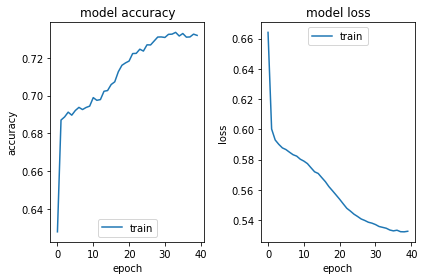

In [39]:
import matplotlib.pyplot as plt

print(model.history.keys())

history = model.history

fig, axs = plt.subplots(1, 2)

axs[0].plot(history['accuracy'])
axs[0].title.set_text('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='lower center')

axs[1].plot(history['loss'])
axs[1].title.set_text('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper center')

plt.tight_layout()
plt.show()

In [30]:
# Grid search to tune hyper parameters
from sklearn import svm
from sklearn.model_selection import GridSearchCV



In [ ]:
# Evaluate model